In [1]:
import pandas as pd
import math
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
import keras


from tensorflow.keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Read the data

In [2]:
df = pd.read_csv(r'C:\Users\MY\Documents\Python Scripts\codeclause intern projects\gender and age detection project\age_gender.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [3]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

# Reshape the images

In [4]:
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

# Normalise images

if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255

# Set some useful variables

input_shape = X_reshaped.shape[1:] 

# Set y

y = df['age'].values

# Train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=123)

# Model

In [6]:
age_model = Sequential()

age_model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))

age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(1, activation='linear'))

age_model.compile(optimizer='adam', loss='mean_absolute_error')

age_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)       

In [7]:
# Callbacks for age model

callbacks = [EarlyStopping(patience=10,min_delta=0.001,restore_best_weights=True),ReduceLROnPlateau(patience = 2,
                               verbose=1,factor=0.5, min_lr = 0.0001)]

In [8]:
history = age_model.fit(X_train, y_train, epochs=20,batch_size=64,callbacks=callbacks,validation_data=(X_test, y_test))

Epoch 1/20

297/297 [==============================] - 102s 301ms/step - loss: 16.0027 - val_loss: 14.1239 - lr: 0.0010
Epoch 2/20
297/297 [==============================] - 87s 291ms/step - loss: 13.2920 - val_loss: 12.9400 - lr: 0.0010
Epoch 3/20
297/297 [==============================] - 88s 297ms/step - loss: 11.8865 - val_loss: 11.2757 - lr: 0.0010
Epoch 4/20
297/297 [==============================] - 88s 295ms/step - loss: 11.1893 - val_loss: 11.3173 - lr: 0.0010
Epoch 5/20
297/297 [==============================] - 87s 293ms/step - loss: 10.7723 - val_loss: 9.7939 - lr: 0.0010
Epoch 6/20
297/297 [==============================] - 131s 440ms/step - loss: 10.3089 - val_loss: 9.4975 - lr: 0.0010
Epoch 7/20
297/297 [==============================] - 89s 300ms/step - loss: 9.8640 - val_loss: 8.9994 - lr: 0.0010
Epoch 8/20
297/297 [==============================] - 88s 294ms/step - loss: 9.5207 - val_loss: 8.4541 - lr: 0.0010
Epoch 9/20
297/297 [==============================] - 88s 2

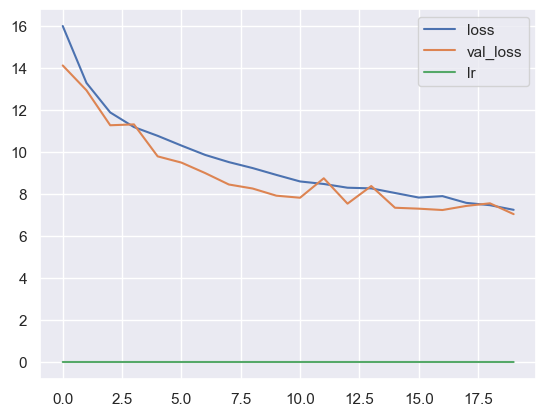

In [9]:
pd.DataFrame(history.history).plot();

In [10]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 9s 63ms/step - loss: 7.0429


# Predictions

In [11]:
y_pred = age_model.predict(X_test)

149/149 [==============================] - 8s 54ms/step


In [12]:
# Man absolute error
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 7.042922554979644


In [13]:
from sklearn.metrics import r2_score

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

R2 score: 0.758


# Face Prediction

In [14]:
import matplotlib.pyplot as plt

def face_prediction(image):
    
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    
    age_predict = int(age_model.predict(x))
    
    plt.imshow(image)
    plt.title("Predicted Age: %d" % age_predict)
    plt.axis('off')

(-0.5, 47.5, 47.5, -0.5)

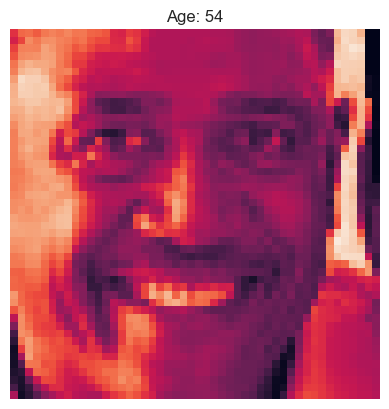

In [15]:

random_face = np.random.choice(len(df))

age = df['age'][random_face]

plt.imshow(df['pixels'][random_face])
plt.title('Age: {0}'.format(age))
plt.axis('off')

1/1 [==============================] - 0s 78ms/step


C:\Users\MY\AppData\Local\Temp\ipykernel_620\4038275351.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_predict = int(age_model.predict(x))


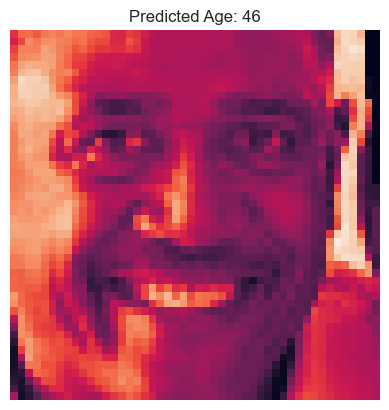

In [16]:
# Model prediction 

face_prediction(df['pixels'][random_face])